In [0]:
from keras.datasets import fashion_mnist

import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time
from sklearn.cluster import KMeans
from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from imageio import imread
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score

#from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score

In [5]:
from keras.callbacks import EarlyStopping
#Loading the data
(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()

#Normalizing the data
train_x = train_x/255.
val_x = val_x/255.

# Reshaping the data
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

input_img = Input(shape=(784,))

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

4423680/4422102 [==============================] - 2s 0us/step




In [0]:
def acc(y_true, y_pred):
    
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

# **KMeans Clustering**

In [12]:
kmeans = KMeans(
    n_clusters=10, init='k-means++',
    n_init=10,max_iter=250, 
    tol=1e-35, random_state=0,verbose = 1
)
y_pred = kmeans.fit_predict(train_x)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2063388.250542678
start iteration
done sorting
end inner loop
Iteration 1, inertia 1996067.4421929389
start iteration
done sorting
end inner loop
Iteration 2, inertia 1979765.4541863643
start iteration
done sorting
end inner loop
Iteration 3, inertia 1971387.4275154877
start iteration
done sorting
end inner loop
Iteration 4, inertia 1967552.0016898636
start iteration
done sorting
end inner loop
Iteration 5, inertia 1965187.6586397982
start iteration
done sorting
end inner loop
Iteration 6, inertia 1962964.1014081663
start iteration
done sorting
end inner loop
Iteration 7, inertia 1960159.6012156857
start iteration
done sorting
end inner loop
Iteration 8, inertia 1955493.9664872827
start iteration
done sorting
end inner loop
Iteration 9, inertia 1947141.2341481792
start iteration
done sorting
end inner loop
Iteration 10, inertia 1939751.4551600933
start iteration
done sorting
end inner loop
Iteratio

In [13]:
y_pred

array([9, 2, 4, ..., 2, 4, 4], dtype=int32)

In [0]:
cluster_labels = infer_cluster_labels(kmeans, train_y)
predicted_Y = infer_data_labels(kmeans.labels_, cluster_labels)

In [16]:
kmeans_acc = metrics.accuracy_score(train_y, predicted_Y)
print(kmeans_acc)

0.5532666666666667


# **Auto-Encoder with KMeans clustering**

In [21]:
# "encoded" is the encoded representation of the input
encoded = Dense(2000, activation='relu')(input_img)
encoded = Dense(1000, activation='relu')(encoded)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(500, activation='relu')(encoded)
decoded = Dense(1000, activation='relu')(decoded)
decoded = Dense(2000, activation='relu')(decoded)
decoded = Dense(784)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2000)              1570000   
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dense_11 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5010      
_________________________________________________________________
dense_13 (Dense)             (None, 500)               5500      
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              5010

In [9]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam',
                      loss='mse',
                      metrics=['accuracy'])

estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

train_history = autoencoder.fit(train_x, train_x, epochs=200, batch_size=64, validation_data=(val_x, val_x), callbacks=[estop])





Train on 60000 samples, validate on 10000 samples
Epoch 1/200





60000/60000 [==============================] - 19s 319us/step - loss: 0.0297 - acc: 0.0140 - val_loss: 0.0214 - val_acc: 0.0249
Epoch 2/200
60000/60000 [==============================] - 14s 237us/step - loss: 0.0184 - acc: 0.0185 - val_loss: 0.0175 - val_acc: 0.0192
Epoch 3/200
60000/60000 [==============================] - 14s 235us/step - loss: 0.0163 - acc: 0.0217 - val_loss: 0.0154 - val_acc: 0.0227
Epoch 4/200
60000/60000 [==============================] - 14s 237us/step - loss: 0.0150 - acc: 0.0271 - val_loss: 0.0145 - val_acc: 0.0284
Epoch 5/200
60000/60000 [==============================] - 14s 235us/step - loss: 0.0142 - acc: 0.0304 - val_loss: 0.0142 - val_acc: 0.0299
Epoch 6/200
60000/60000 [==============================] - 14s 235us/step - loss: 0.0137 - acc: 0.0328 - val_loss: 0.0137 - val_acc: 0.0301
Epoch 7/200
60000/60000 [==============================] - 14s 237us/step - loss: 0.0133 - acc: 0.034

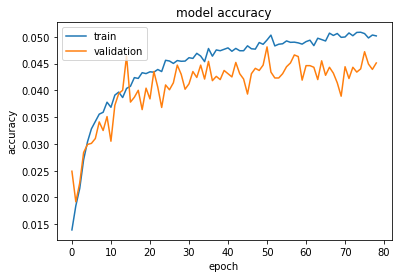

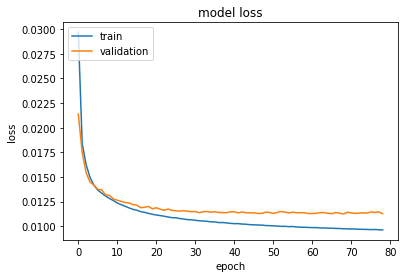

In [12]:
import matplotlib.pyplot as plt

#  "Accuracy"
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(10):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [11]:
encoder = keras.backend.function([autoencoder.layers[0].input],[autoencoder.layers[4].output]) 
encoded_image = encoder([train_x])[0].reshape(-1,10)

km = KMeans(
      n_clusters=10, init='k-means++',
      n_init=10, max_iter=300,
      tol=1e-35, random_state=0
  )

y_km  = km.fit_predict(encoded_image)

cluster_labels = infer_cluster_labels(km, train_y)
predicted_Y = infer_data_labels(km.labels_, cluster_labels)

from sklearn import metrics
kmeans_acc = metrics.accuracy_score(train_y, predicted_Y)
print(kmeans_acc)


0.6079166666666667


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cm=metrics.confusion_matrix(train_y, y_km)

print(cm)

[[ 806 4699    0   15   40    8   72  268   72   20]
 [ 291   44    0   41 5529    1   20   30   29   15]
 [  69   37    0 2195   11    2  770 2846   57   13]
 [5366  188    0    7   94    3   99  226   14    3]
 [ 839   13    0 1939    8    1 2266  898   33    3]
 [   3    5  781    5    1 1395   15   43   72 3680]
 [ 600 1349    0  466   10    5  537 2868  155   10]
 [   0    0 1400    1    0   35    1    0   13 4550]
 [ 197   19   42   17    9   35 2466  237 2870  108]
 [   0    1 2836    2    0 3096    0    0   12   53]]


# **Auto Encoder with Gaussian Mixture Models**

In [0]:
def infer_cluster_labels_GMM(gmm, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """
    inferred_labels = {}

    for i in range(10):

        # find index of points in cluster
        labels = []
        index = np.where(gmm == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels_GMM(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [14]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10,tol=1e-10,max_iter=300,random_state=0,verbose=1)
output = gmm.fit_predict(encoded_image)

gmm_cluster_labels = infer_cluster_labels_GMM(output, train_y)
gmm_predicted_Y = infer_data_labels_GMM(output, gmm_cluster_labels)

gmm_acc = metrics.accuracy_score(train_y, gmm_predicted_Y)
print(gmm_acc)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
  Iteration 290
  Iteration 300
Initialization converged: False


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


0.6223666666666666


In [15]:
print(gmm_acc)

0.6223666666666666


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cm=confusion_matrix(train_y, gmm_predicted_Y)

print(cm)

[[4243    0   24  704    0  254    0    0  775    0]
 [   7 5348    5  277    0  328    0    8   27    0]
 [  16    0 3715 1468    0  395    0    0  406    0]
 [ 177    8    7 5442    0  122    0    0  244    0]
 [  10    1 3689 1808    0  315    0    0  177    0]
 [   0    0    0    4    0 3286    0 2584    7  119]
 [1015    0 1570 2122    0  310    0    0  983    0]
 [   0    0    0    0    0  185    0 4502    2 1311]
 [   1    0   15   38    0  646    0   21 5275    4]
 [   0    0    0    1    0  387    0   79    2 5531]]
